## **Activity Cliffs**

This script was adapted by Alberto Marbán, originally developed by Raziel Cedillo-González, Fernanda I. Saldívar-González and Luis Rivera available at https://difacquim.gitbook.io/quimioinformatica


Empty cell

In [10]:
!pip install jupyter-dash  
!pip install dash-bootstrap-components
!pip install rdkit
!pip install molplotly 
!pip install Pillow
!pip install datamol
!pip install sklearn
!pip install yellowbrick
!pip install molfeat 
!pip install plotly  

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 12.6 MB/s eta 0:00:00


In [2]:
import time
import os
import sys
import random
import requests
import pandas as pd
import rdkit as rk
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdFMCS
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole, rdDepictor
from rdkit.Geometry import DataStructs
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image, ImageDraw, ImageFont
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
from pydoc import classify_class_attrs
import base64
from io import BytesIO
import datamol as dm
from molfeat.calc import FPCalculator, FP_FUNCS
from molfeat.trans import MoleculeTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from yellowbrick.regressor import prediction_error, residuals_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, classification_report, confusion_matrix, accuracy_score
import networkx as nx
from functools import reduce

# RDKit and IPython configurations
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize = 25

# Measure the loading time
tic = time.time()
# Your imports go here
toc = time.time()

# Print the total time taken to load all modules
print("Time to load libraries: " + str(round(toc - tic, 2)) + " seconds")


Time to load libraries: 0.0 seconds


## **Loading and reading the database**

In [67]:
# Load the DataFrame from a CSV file
file_path = 'STADS_SALI.csv'  # Change this path according to the location of your file
database_original_direct = pd.read_csv(file_path)

# Print the information about the DataFrame, such as column names, non-null counts, and data types
print(database_original_direct.info())

# Display the first 2 rows of the DataFrame to check the data loading
database_original_direct[0:2]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Structure of NEW_SMILES [idcode]  217 non-null    object 
 1   NEW_SMILES                        217 non-null    object 
 2   pIC50                             217 non-null    float64
 3   amw                               217 non-null    float64
 4   lipinskiHBA                       217 non-null    int64  
 5   lipinskiHBD                       217 non-null    int64  
 6   NumRotatableBonds                 217 non-null    int64  
 7   NumHBD                            217 non-null    int64  
 8   NumHBA                            217 non-null    int64  
 9   NumHeavyAtoms                     217 non-null    int64  
 10  NumAtoms                          217 non-null    int64  
 11  NumHeteroatoms                    217 non-null    int64  
 12  NumAmide

Structure of NEW_SMILES [idcode]  \
0  fcoH`@DZSdBtfYgV[eWyVU[tQsZhHIJj`hF@@@   
1     fakI@@DRCtBSLnsLj{k[tRuZuUTmUHPI@@@   

                                       NEW_SMILES     pIC50      amw  \
0  CC(=O)N(C)Cc1cc(C(=O)N(C)Cc2cc3ccccc3n2C)ccc1N  5.173925  378.476   
1       CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  4.028260  322.412   

   lipinskiHBA  lipinskiHBD  NumRotatableBonds  NumHBD  NumHBA  NumHeavyAtoms  \
0            6            2                  5       1       4             28   
1            5            2                  5       2       3             24   

   ...     chi3n     chi4n  hallKierAlpha     kappa1    kappa2    kappa3  \
0  ...  5.131905  3.275526          -3.28  19.480717  7.760914  3.856356   
1  ...  4.380649  2.883636          -2.82  16.052453  6.743193  3.399939   

        Phi  Shape Index  Molecular Flexibility  Molecular Complexity  
0  5.399577      0.53571                0.60672               0.78413  
1  4.510200      0.62500                0.55410               0.75761  

[2 rows x 48 columns]

In [68]:
len(database_original_direct)

217

Reference: https://pubs.rsc.org/en/content/articlehtml/2023/dd/d3dd00098b

In [69]:
database_original_direct.columns


Index(['Structure of NEW_SMILES [idcode]', 'NEW_SMILES', 'pIC50', 'amw',
       'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA',
       'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds',
       'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings',
       'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles',
       'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'NumSpiroAtoms',
       'NumBridgeheadAtoms', 'NumAtomStereoCenters',
       'NumUnspecifiedAtomStereoCenters', 'labuteASA', 'tpsa', 'CrippenClogP',
       'CrippenMR', 'chi0v', 'chi1v', 'chi2v', 'chi3v', 'chi4v', 'chi0n',
       'chi1n', 'chi2n', 'chi3n', 'chi4n', 'hallKierAlpha', 'kappa1', 'kappa2',
       'kappa3', 'Phi', 'Shape Index', 'Molecular Flexibility',
       'Molecular Complexity'],
      dtype='object')

In [70]:
# Reduce the DataFrame to only include essential columns for analysis
db_treatment = database_original_direct.drop(database_original_direct.columns.difference([
    'molecule_chembl_id', 'NEW_SMILES', 'pIC50']), axis=1)

# Rename the column for clarity, although this seems to be targeting a column not listed in the drop statement above
db_treatment = db_treatment.rename(columns={'standard_value': 'IC50'})

# Sort the DataFrame by the 'pIC50' values to organize the data for better visualization in subsequent sections
db_treatment = db_treatment.sort_values(by=['pIC50']).reset_index(drop=True)

# Create a new column 'InChI' by converting SMILES to InChI keys for each molecule
InChI_column = []
for i in db_treatment['NEW_SMILES']:  # For each compound 'i' in the database, convert its SMILES representation to InChI.
    mol = Chem.MolFromSmiles(i)  # Convert SMILES string to an RDKit molecule object
    n_inchi = Chem.MolToInchiKey(mol)  # Convert molecule object to InChI key
    InChI_column.append(n_inchi)
db_treatment.insert(2, 'InChI', InChI_column)  # Insert the newly created InChI column into the DataFrame.

# Print the shape of the DataFrame before removing duplicates to track changes
print(f"Original Data: {db_treatment.shape}")

# Remove duplicate molecules based on 'InChI' and 'NEW_SMILES' columns
db_treatment.drop_duplicates(subset=['InChI', 'NEW_SMILES'], inplace=True)

# Print the shape of the DataFrame after duplicate removal to confirm the effect
print(f"Data after removing duplicates: {db_treatment.shape}")

# Display the processed DataFrame
db_treatment


Original Data: (217, 3)
Data after removing duplicates: (217, 3)


NEW_SMILES     pIC50  \
0            CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  4.028260   
1              CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O  4.076756   
2                COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1  4.179142   
3                        Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1  4.292430   
4                        Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1  4.294992   
..                                                 ...       ...   
212  Cc1c(CN(C)C(=O)CC=c2cnc3c(c2)CC2(CCN(C)CC2)C(=...  7.853872   
213                         CCc1cc(O)c(Oc2cccnc2F)cc1F  7.886057   
214       O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1  7.886057   
215                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F  7.920819   
216                         CCc1cc(O)c(Oc2ccccc2F)cc1F  8.096910   

                           InChI  
0    CAEFFYSYRJMIGG-UHFFFAOYSA-N  
1    ZTGHWUWBQNCCOH-UHFFFAOYSA-N  
2    GOGOZAKGICXBRX-UHFFFAOYSA-N  
3    OPCSLBQDZDQIHM-UHFFFAOYSA-N  
4    VSWGLBAVZHBJDE-UHFFFAOYSA-N  
..                           ...  
212  QCMFOLDECFWRKC-UHFFFAOYSA-N  
213  BJEMGBNLIALWCL-UHFFFAOYSA-N  
214  POGDHEDJRPDVRQ-UHFFFAOYSA-N  
215  QUHARGDBJJUOEB-UHFFFAOYSA-N  
216  MUHZCNPYLSMOCX-UHFFFAOYSA-N  

[217 rows x 3 columns]

In [71]:
# Remove rows with null values in the 'pIC50' column
db_treatment_cleaned = db_treatment.dropna(subset=['pIC50'])

# db_treatment_cleaned now only contains rows with non-null values in the 'pIC50' column
# This ensures that the dataset is ready for analysis without data integrity issues caused by missing values.

# Print the shape of the cleaned DataFrame to show the number of rows and columns remaining after null removal
print(f"DataFrame shape after removing null values: {db_treatment_cleaned.shape}.")

# Display the first few rows of the cleaned DataFrame to verify the removal of null values and to inspect the dataset
print(db_treatment_cleaned.head())


DataFrame shape after removing null values: (217, 3).
                                  NEW_SMILES     pIC50  \
0  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  4.028260   
1    CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O  4.076756   
2      COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1  4.179142   
3              Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1  4.292430   
4              Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1  4.294992   

                         InChI  
0  CAEFFYSYRJMIGG-UHFFFAOYSA-N  
1  ZTGHWUWBQNCCOH-UHFFFAOYSA-N  
2  GOGOZAKGICXBRX-UHFFFAOYSA-N  
3  OPCSLBQDZDQIHM-UHFFFAOYSA-N  
4  VSWGLBAVZHBJDE-UHFFFAOYSA-N  


In [72]:
db_treatment=db_treatment_cleaned

In [73]:
db_treatment

NEW_SMILES     pIC50  \
0            CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  4.028260   
1              CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O  4.076756   
2                COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1  4.179142   
3                        Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1  4.292430   
4                        Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1  4.294992   
..                                                 ...       ...   
212  Cc1c(CN(C)C(=O)CC=c2cnc3c(c2)CC2(CCN(C)CC2)C(=...  7.853872   
213                         CCc1cc(O)c(Oc2cccnc2F)cc1F  7.886057   
214       O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1  7.886057   
215                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F  7.920819   
216                         CCc1cc(O)c(Oc2ccccc2F)cc1F  8.096910   

                           InChI  
0    CAEFFYSYRJMIGG-UHFFFAOYSA-N  
1    ZTGHWUWBQNCCOH-UHFFFAOYSA-N  
2    GOGOZAKGICXBRX-UHFFFAOYSA-N  
3    OPCSLBQDZDQIHM-UHFFFAOYSA-N  
4    VSWGLBAVZHBJDE-UHFFFAOYSA-N  
..                           ...  
212  QCMFOLDECFWRKC-UHFFFAOYSA-N  
213  BJEMGBNLIALWCL-UHFFFAOYSA-N  
214  POGDHEDJRPDVRQ-UHFFFAOYSA-N  
215  QUHARGDBJJUOEB-UHFFFAOYSA-N  
216  MUHZCNPYLSMOCX-UHFFFAOYSA-N  

[217 rows x 3 columns]

## **Calculating Activity difference**

empty cell

Iterative case for each compound in the preprocessed database. A main loop selects a fixed compound for comparison, while a sub-loop iterates through the remaining compounds, starting one position ahead. All comparison results are stored in a predefined list.

In [74]:
comparacion_actividad = []  # List to store comparison results

# Main iteration loop and choice of fixed comparison element
for i in range(len(db_treatment)):
    elemento_fijo = db_treatment.iloc[i]  # Note: 'iloc' is used for indexing by integers or booleans.

    # Sub-loop: choice of variable element and comparison.
    for j in range(i+1, len(db_treatment)):  # "i+1" ensures that iteration starts from the element after 'elemento_fijo'.
        elemento_variable = db_treatment.iloc[j]

        # Comparison of activity values.
        diferencia_actividad = abs(elemento_fijo["pIC50"] - elemento_variable["pIC50"])  # Calculate the absolute difference in pIC50 values

        # Addition of comparison cases to the result list created in the first step.
        comparacion_actividad.append({
            'Compound A': elemento_fijo['InChI'],  # InChI of the fixed compound
            'pIC50 A': elemento_fijo['pIC50'],  # pIC50 of the fixed compound
            'Compound B': elemento_variable['InChI'],  # InChI of the variable compound
            'pIC50 B': elemento_variable['pIC50'],  # pIC50 of the variable compound
            'Activity difference': diferencia_actividad  # The calculated difference in activity
        })

# DataFrame with comparison results.
actividad_db = pd.DataFrame(comparacion_actividad)
actividad_db

Compound A   pIC50 A                   Compound B  \
0      CAEFFYSYRJMIGG-UHFFFAOYSA-N  4.028260  ZTGHWUWBQNCCOH-UHFFFAOYSA-N   
1      CAEFFYSYRJMIGG-UHFFFAOYSA-N  4.028260  GOGOZAKGICXBRX-UHFFFAOYSA-N   
2      CAEFFYSYRJMIGG-UHFFFAOYSA-N  4.028260  OPCSLBQDZDQIHM-UHFFFAOYSA-N   
3      CAEFFYSYRJMIGG-UHFFFAOYSA-N  4.028260  VSWGLBAVZHBJDE-UHFFFAOYSA-N   
4      CAEFFYSYRJMIGG-UHFFFAOYSA-N  4.028260  BZVRVXDHDUXYOD-UHFFFAOYSA-N   
...                            ...       ...                          ...   
23431  BJEMGBNLIALWCL-UHFFFAOYSA-N  7.886057  QUHARGDBJJUOEB-UHFFFAOYSA-N   
23432  BJEMGBNLIALWCL-UHFFFAOYSA-N  7.886057  MUHZCNPYLSMOCX-UHFFFAOYSA-N   
23433  POGDHEDJRPDVRQ-UHFFFAOYSA-N  7.886057  QUHARGDBJJUOEB-UHFFFAOYSA-N   
23434  POGDHEDJRPDVRQ-UHFFFAOYSA-N  7.886057  MUHZCNPYLSMOCX-UHFFFAOYSA-N   
23435  QUHARGDBJJUOEB-UHFFFAOYSA-N  7.920819  MUHZCNPYLSMOCX-UHFFFAOYSA-N   

        pIC50 B  Activity difference  
0      4.076756             0.048496  
1      4.179142             0.150882  
2      4.292430             0.264169  
3      4.294992             0.266732  
4      4.301030             0.272770  
...         ...                  ...  
23431  7.920819             0.034762  
23432  8.096910             0.210853  
23433  7.920819             0.034762  
23434  8.096910             0.210853  
23435  8.096910             0.176091  

[23436 rows x 5 columns]

## **Molecular Similarity Calculation**

This section describes an iterative loop to generate molecular fingerprints (ECFP4 using RDKit) and calculate similarity using the Tanimoto coefficient.

## **Iterative Cycle**

In [75]:
import time
tic = time.time()
structure_comparison = []  # List to store comparison cases.

# Main loop iterating over all compounds in the database, using their SMILES representation.
for i in range(len(db_treatment)):
    fixed_compound_id = db_treatment.loc[[i], ["InChI"]]
    fixed_compound_df = db_treatment.loc[[i], ["NEW_SMILES"]]
    # As each element is iterated, it is recognized not directly as a string (which is needed for the 'GetMorgan' method) but as a DataFrame, hence 'to_string' method is used for conversion.
    fixed_compound_str = fixed_compound_df.to_string(index=False, header=False)
    # With the compound in SMILES representation and string format, we can now use RDKit to generate a "mol" object.
    fixed_compound_mol = Chem.MolFromSmiles(fixed_compound_str)
    # Morgan fingerprint is generated from the mol object. The user must define a radius for the fingerprint generation; here we use "2". "nBits = 2048" is the size of the generated bit vector.
    fps_fixed_compound = AllChem.GetMorganFingerprintAsBitVect(fixed_compound_mol, 2, nBits=2048)

    # Sub-loop to generate the fingerprint for "variable element".
    for j in range(i+1, len(db_treatment)):
        variable_compound_id = db_treatment.loc[[j], ["InChI"]]
        variable_compound_df = db_treatment.loc[[j], ["NEW_SMILES"]]
        variable_compound_str = variable_compound_df.to_string(index=False, header=False)
        variable_compound_mol = Chem.MolFromSmiles(variable_compound_str)
        fps_variable_compound = AllChem.GetMorganFingerprintAsBitVect(variable_compound_mol, 2, nBits=2048)

        # Calculate the structural similarity using Tanimoto coefficient.
        structural_difference = DataStructs.TanimotoSimilarity(fps_fixed_compound, fps_variable_compound)

        # Append comparison cases to the results list.
        structure_comparison.append({
            "Compound A": fixed_compound_id.to_string(index=False, header=False),
            "Smiles A": fixed_compound_str,
            "Compound B": variable_compound_id.to_string(index=False, header=False),
            "Smiles B": variable_compound_str,
            "Structure Similarity (Tanimoto)": structural_difference
        })

# DataFrame containing all possible comparisons of structural similarity.
structure_db = pd.DataFrame(structure_comparison)
toc = time.time()
print("Time: " + str((toc - tic)) + " s")
structure_db


[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerator
[21:31:00] DEPRECATION WARNING: please use MorganGenerat

Time: 65.95800352096558 s


Compound A  \
0      CAEFFYSYRJMIGG-UHFFFAOYSA-N   
1      CAEFFYSYRJMIGG-UHFFFAOYSA-N   
2      CAEFFYSYRJMIGG-UHFFFAOYSA-N   
3      CAEFFYSYRJMIGG-UHFFFAOYSA-N   
4      CAEFFYSYRJMIGG-UHFFFAOYSA-N   
...                            ...   
23431  BJEMGBNLIALWCL-UHFFFAOYSA-N   
23432  BJEMGBNLIALWCL-UHFFFAOYSA-N   
23433  POGDHEDJRPDVRQ-UHFFFAOYSA-N   
23434  POGDHEDJRPDVRQ-UHFFFAOYSA-N   
23435  QUHARGDBJJUOEB-UHFFFAOYSA-N   

                                           Smiles A  \
0         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
1         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
2         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
3         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
4         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
...                                             ...   
23431                    CCc1cc(O)c(Oc2cccnc2F)cc1F   
23432                    CCc1cc(O)c(Oc2cccnc2F)cc1F   
23433  O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1   
23434  O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1   
23435            CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F   

                        Compound B  \
0      ZTGHWUWBQNCCOH-UHFFFAOYSA-N   
1      GOGOZAKGICXBRX-UHFFFAOYSA-N   
2      OPCSLBQDZDQIHM-UHFFFAOYSA-N   
3      VSWGLBAVZHBJDE-UHFFFAOYSA-N   
4      BZVRVXDHDUXYOD-UHFFFAOYSA-N   
...                            ...   
23431  QUHARGDBJJUOEB-UHFFFAOYSA-N   
23432  MUHZCNPYLSMOCX-UHFFFAOYSA-N   
23433  QUHARGDBJJUOEB-UHFFFAOYSA-N   
23434  MUHZCNPYLSMOCX-UHFFFAOYSA-N   
23435  MUHZCNPYLSMOCX-UHFFFAOYSA-N   

                                                Smiles B  \
0                CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O   
1                  COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1   
2                          Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1   
3                          Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1   
4      Cc1cc(O)c(C)c(O)c1C(=O)N1CCc2c(n(Cc3ccc(O)cc3)...   
...                                                  ...   
23431                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F   
23432                         CCc1cc(O)c(Oc2ccccc2F)cc1F   
23433                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F   
23434                         CCc1cc(O)c(Oc2ccccc2F)cc1F   
23435                         CCc1cc(O)c(Oc2ccccc2F)cc1F   

       Structure Similarity (Tanimoto)  
0                             0.116883  
1                             0.152778  
2                             0.105263  
3                             0.105263  
4                             0.195402  
...                                ...  
23431                         0.530612  
23432                         0.682927  
23433                         0.117647  
23434                         0.126582  
23435                         0.627907  

[23436 rows x 5 columns]


## **Similarity Matrix**

In [76]:
def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=1024)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=1024)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s

In [77]:
db_treatment.sort_values(by=["InChI"], ascending=False, inplace=True) #Sort by ID for better visualization
db_treatment.reset_index(drop=True, inplace=True)

tic =time.time()
hmap_similarity=pd.DataFrame()
for i in db_treatment.index:
    for j in db_treatment.index:
        a=db_treatment.loc[i].at['NEW_SMILES']
        b=db_treatment.loc[j].at['NEW_SMILES']
        alignment= tanimoto_calc(a,b)
        hmap_similarity.loc[db_treatment.loc[i,'InChI'],db_treatment.loc[j,'InChI']]=alignment
toc =time.time()
print("Time: "+ str((toc-tic))+" s")

hmap_similarity

[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerator
[21:32:06] DEPRECATION WARNING: please use MorganGenerat

Time: 49.801584243774414 s


ZZBZKXMPCZBLRH-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        1.000   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        0.107   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        0.102   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        0.120   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        0.127   
...                                                  ...   
AKGBPZQBSBLENJ-DUXPYHPUSA-N                        0.111   
AKFPMLBVLWZSQX-UHFFFAOYSA-N                        0.143   
AHEABZRNPRRNSG-UHFFFAOYSA-N                        0.756   
AGJJZGNTZOOCTJ-UHFFFAOYSA-N                        0.653   
ADXYEWMDAGIULV-UHFFFAOYSA-N                        0.115   

                             ZVKZXXKLGAUUAV-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        0.107   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        1.000   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        0.095   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        0.106   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        0.150   
...                                                  ...   
AKGBPZQBSBLENJ-DUXPYHPUSA-N                        0.070   
AKFPMLBVLWZSQX-UHFFFAOYSA-N                        0.137   
AHEABZRNPRRNSG-UHFFFAOYSA-N                        0.121   
AGJJZGNTZOOCTJ-UHFFFAOYSA-N                        0.132   
ADXYEWMDAGIULV-UHFFFAOYSA-N                        0.821   

                             ZTGHWUWBQNCCOH-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        0.102   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        0.095   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        1.000   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        0.080   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        0.117   
...                                                  ...   
AKGBPZQBSBLENJ-DUXPYHPUSA-N                        0.109   
AKFPMLBVLWZSQX-UHFFFAOYSA-N                        0.149   
AHEABZRNPRRNSG-UHFFFAOYSA-N                        0.088   
AGJJZGNTZOOCTJ-UHFFFAOYSA-N                        0.093   
ADXYEWMDAGIULV-UHFFFAOYSA-N                        0.093   

                             ZQGGTHYGMIQIMR-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        0.120   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        0.106   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        0.080   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        1.000   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        0.107   
...                                                  ...   
AKGBPZQBSBLENJ-DUXPYHPUSA-N                        0.310   
AKFPMLBVLWZSQX-UHFFFAOYSA-N                        0.098   
AHEABZRNPRRNSG-UHFFFAOYSA-N                        0.174   
AGJJZGNTZOOCTJ-UHFFFAOYSA-N                        0.156   
ADXYEWMDAGIULV-UHFFFAOYSA-N                        0.097   

                             ZNIKKTWPMSNEAW-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        0.127   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        0.150   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        0.117   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        0.107   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        1.000   
...                                                  ...   
AKGBPZQBSBLENJ-DUXPYHPUSA-N                        0.085   
AKFPMLBVLWZSQX-UHFFFAOYSA-N                        0.451   
AHEABZRNPRRNSG-UHFFFAOYSA-N                        0.105   
AGJJZGNTZOOCTJ-UHFFFAOYSA-N                        0.109   
ADXYEWMDAGIULV-UHFFFAOYSA-N                        0.154   

                             ZITQQXWDPRWBLK-UHFFFAOYSA-N  \
ZZBZKXMPCZBLRH-UHFFFAOYSA-N                        0.121   
ZVKZXXKLGAUUAV-UHFFFAOYSA-N                        0.588   
ZTGHWUWBQNCCOH-UHFFFAOYSA-N                        0.122   
ZQGGTHYGMIQIMR-UHFFFAOYSA-N                        0.130   
ZNIKKTWPMSNEAW-UHFFFAOYSA-N                        0.158   
...                                                  ...   
AKGB

## **Determination of SALI values**

In [78]:
# Merge the activity and structure DataFrames based on the compound identifiers
merge = actividad_db.merge(right=structure_db, on=['Compound A', 'Compound B'], suffixes=('', '_right'))  # Combine the DataFrames

# Select specific columns for the merged DataFrame
merge = merge[['Compound A', 'pIC50 A', 'Smiles A', 'Compound B', 'pIC50 B', 'Smiles B', 'Activity difference', 'Structure Similarity (Tanimoto)']]

# Round the pIC50 values and differences to four decimal places
merge['pIC50 A'] = merge['pIC50 A'].round(4)
merge['pIC50 B'] = merge['pIC50 B'].round(4)
merge['Activity difference'] = merge['Activity difference'].round(4)
merge['Structure similarity (Tanimoto)'] = merge['Structure Similarity (Tanimoto)'].round(4)

# Calculate the SALI (Structural Activity Likeness Index) value directly without iterating over all rows
merge['SALI value'] = (merge['Activity difference'] / (1 - merge['Structure Similarity (Tanimoto)'])).round(4)

# Display the updated merge DataFrame
merge


Compound A  pIC50 A  \
0      CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
1      CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
2      CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
3      CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
4      CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
...                            ...      ...   
23431  BJEMGBNLIALWCL-UHFFFAOYSA-N   7.8861   
23432  BJEMGBNLIALWCL-UHFFFAOYSA-N   7.8861   
23433  POGDHEDJRPDVRQ-UHFFFAOYSA-N   7.8861   
23434  POGDHEDJRPDVRQ-UHFFFAOYSA-N   7.8861   
23435  QUHARGDBJJUOEB-UHFFFAOYSA-N   7.9208   

                                           Smiles A  \
0         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
1         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
2         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
3         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
4         CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1   
...                                             ...   
23431                    CCc1cc(O)c(Oc2cccnc2F)cc1F   
23432                    CCc1cc(O)c(Oc2cccnc2F)cc1F   
23433  O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1   
23434  O=C1CCc2cc(=CCC(=O)N3CC(OCc4cccs4)C3)cnc2=N1   
23435            CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F   

                        Compound B  pIC50 B  \
0      ZTGHWUWBQNCCOH-UHFFFAOYSA-N   4.0768   
1      GOGOZAKGICXBRX-UHFFFAOYSA-N   4.1791   
2      OPCSLBQDZDQIHM-UHFFFAOYSA-N   4.2924   
3      VSWGLBAVZHBJDE-UHFFFAOYSA-N   4.2950   
4      BZVRVXDHDUXYOD-UHFFFAOYSA-N   4.3010   
...                            ...      ...   
23431  QUHARGDBJJUOEB-UHFFFAOYSA-N   7.9208   
23432  MUHZCNPYLSMOCX-UHFFFAOYSA-N   8.0969   
23433  QUHARGDBJJUOEB-UHFFFAOYSA-N   7.9208   
23434  MUHZCNPYLSMOCX-UHFFFAOYSA-N   8.0969   
23435  MUHZCNPYLSMOCX-UHFFFAOYSA-N   8.0969   

                                                Smiles B  Activity difference  \
0                CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O               0.0485   
1                  COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1               0.1509   
2                          Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1               0.2642   
3                          Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1               0.2667   
4      Cc1cc(O)c(C)c(O)c1C(=O)N1CCc2c(n(Cc3ccc(O)cc3)...               0.2728   
...                                                  ...                  ...   
23431                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F               0.0348   
23432                         CCc1cc(O)c(Oc2ccccc2F)cc1F               0.2109   
23433                 CCc1cc(O)c(Oc2ccc(C(N)=O)cc2F)cc1F               0.0348   
23434                         CCc1cc(O)c(Oc2ccccc2F)cc1F               0.2109   
23435                         CCc1cc(O)c(Oc2ccccc2F)cc1F               0.1761   

       Structure Similarity (Tanimoto)  Structure similarity (Tanimoto)  \
0                             0.116883                           0.1169   
1                             0.152778                           0.1528   
2                             0.105263                           0.1053   
3                             0.105263                           0.1053   
4                             0.195402                           0.1954   
...                                ...                              ...   
23431                         0.530612                           0.5306   
23432                         0.682927                           0.6829   
23433                         0.117647                           0.1176   
23434                         0.126582                           0.1266   
23435                         0.627907                           0.6279   

       SALI value  
0          0.0549  
1          0.1781  
2          0.2953  
3          0.2981  
4          0.3391  
...           ...  
23431      0.0741  
23432      0.6651  
23433      0.0394  
23434      0.2415  
23435      0.4733  

[23436 rows x 10 columns]

In [79]:
# this command ensures that 'merge' is now formatted as a pandas DataFrame.
df_merge = pd.DataFrame(merge)

In [80]:
df_merge.head()

Compound A  pIC50 A  \
0  CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
1  CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
2  CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
3  CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   
4  CAEFFYSYRJMIGG-UHFFFAOYSA-N   4.0283   

                                    Smiles A                   Compound B  \
0  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  ZTGHWUWBQNCCOH-UHFFFAOYSA-N   
1  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  GOGOZAKGICXBRX-UHFFFAOYSA-N   
2  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  OPCSLBQDZDQIHM-UHFFFAOYSA-N   
3  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  VSWGLBAVZHBJDE-UHFFFAOYSA-N   
4  CN(Cc1cc2ccccc2n1C)C(=O)CCc1ccc(=N)[nH]c1  BZVRVXDHDUXYOD-UHFFFAOYSA-N   

   pIC50 B                                           Smiles B  \
0   4.0768            CC(C)=CCc1c(O)cc(-c2cc3ccc(O)cc3o2)cc1O   
1   4.1791              COc1ccc(-c2c[nH]c(Cc3ccc(C)cc3)n2)cc1   
2   4.2924                      Cc1ccc(Cc2noc(-c3ccsc3)n2)cc1   
3   4.2950                      Cc1ccc(Cc2nc(-c3ccsc3)no2)cc1   
4   4.3010  Cc1cc(O)c(C)c(O)c1C(=O)N1CCc2c(n(Cc3ccc(O)cc3)...   

   Activity difference  Structure Similarity (Tanimoto)  \
0               0.0485                         0.116883   
1               0.1509                         0.152778   
2               0.2642                         0.105263   
3               0.2667                         0.105263   
4               0.2728                         0.195402   

   Structure similarity (Tanimoto)  SALI value  
0                           0.1169      0.0549  
1                           0.1528      0.1781  
2                           0.1053      0.2953  
3                           0.1053      0.2981  
4                           0.1954      0.3391

## **Section 4: Data Visualization and Analysis**
The choice of metric to define whether something is an activity cliff (AC) is based on quartile 3 (Q3) for activity difference and pIC<sub>50</sub>. A high SALI value suggests that the compounds are structurally similar but have very different biological or chemical effects.

Un valor alto de SALI sugiere que los compuestos son estructuralmente similares pero tienen efectos biológicos o químicos muy diferentes.

## **SAS map o Panorama de actividad**

In [81]:
# Data for the scatter plot
similarity = merge['Structure similarity (Tanimoto)']
activity_difference = merge['Activity difference']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(similarity, activity_difference, color='gray', alpha=0.5, label='Compound Pair')

# Adding title and labels
plt.title('SAS Map')
plt.xlabel('Structure similarity (Tanimoto)')
plt.ylabel('Activity difference')

# Enabling grid
plt.grid(True)

# Adding a legend to describe the data points
plt.legend(title='Legend')

# Display the plot
plt.show()


In [82]:
similarity

0        0.1169
1        0.1528
2        0.1053
3        0.1053
4        0.1954
          ...  
23431    0.5306
23432    0.6829
23433    0.1176
23434    0.1266
23435    0.6279
Name: Structure similarity (Tanimoto), Length: 23436, dtype: float64

In [83]:
activity_difference

0        0.0485
1        0.1509
2        0.2642
3        0.2667
4        0.2728
          ...  
23431    0.0348
23432    0.2109
23433    0.0348
23434    0.2109
23435    0.1761
Name: Activity difference, Length: 23436, dtype: float64

In [84]:
# Create a DataFrame from pandas for each data lists
df_similarity = pd.DataFrame({'Structure similarity (Tanimoto)': similarity})
df_activity_difference = pd.DataFrame({'Activity difference': activity_difference})

image.png

<a name='4.2'></a>
## **Identificación de "activity cliffs" (ACs).**

In [93]:
def SAS_map(df, similarity_column, dif_activity_col, sali_col, umbral_x=None, umbral_y=None, set_title=str):
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid", font_scale=1.2)

    # Plot all points with low opacity to show overall distribution
    plt.scatter(df[similarity_column], df[dif_activity_col], color='gray', alpha=0.2)

    # If thresholds are provided, highlight points in the fourth quadrant
    if umbral_x is not None and umbral_y is not None:
        puntos_cuarto_cuadrante = df[(df[similarity_column] > umbral_x) & (df[dif_activity_col] > umbral_y)]
        scatter = plt.scatter(puntos_cuarto_cuadrante[similarity_column], puntos_cuarto_cuadrante[dif_activity_col],
                              c=puntos_cuarto_cuadrante[sali_col], cmap='plasma', s=100, alpha=0.8)
        plt.colorbar(scatter, label='SALI value')  # Add a colorbar for SALI values
        # Add threshold lines with labels
        plt.axvline(x=umbral_x, color='green', linestyle='--', label='Threshold X: {}'.format(umbral_x))
        plt.axhline(y=umbral_y, color='blue', linestyle='--', label='Threshold Y: {}'.format(umbral_y))
    else:
        # Color all points by SALI value if no thresholds are given
        scatter = plt.scatter(df[similarity_column], df[dif_activity_col],
                              c=df[sali_col], cmap='plasma', s=100, alpha=0.8)
        plt.colorbar(scatter, label='SALI value')

    # Setting titles and labels
    plt.title(set_title)
    plt.xlabel(similarity_column)
    plt.ylabel(dif_activity_col)
    plt.grid(True)
    plt.legend()
    plt.show()


C:\Users\makra\AppData\Local\Temp\ipykernel_10752\2986914564.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



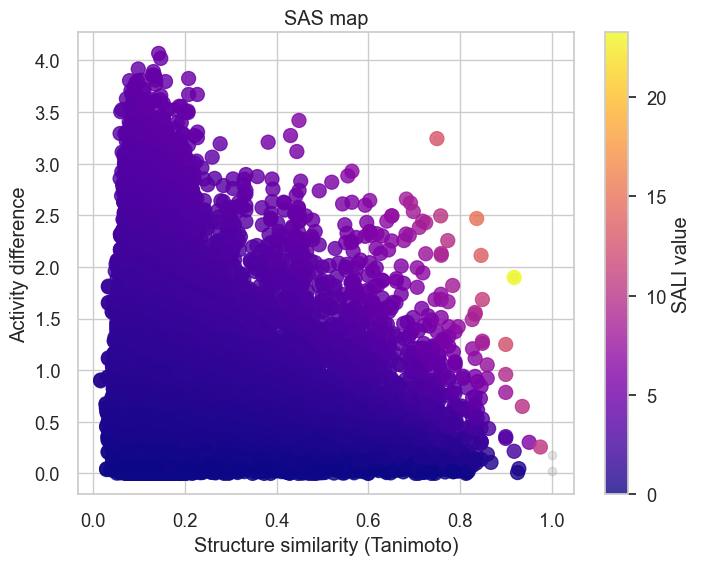

In [95]:
SAS_map(merge, similarity_column='Structure similarity (Tanimoto)', dif_activity_col='Activity difference',
        sali_col='SALI value', set_title= 'SAS map')

In [96]:
# Display statistics for the 'Activity difference' column
activity_diff_stats = merge['Activity difference'].describe()
print(f"Statistics for the 'Activity difference' column:\n{activity_diff_stats}\n")

# Display statistics for the 'Structural Similarity (Tanimoto)' column
structural_sim_stats = merge['Structure similarity (Tanimoto)'].describe()
print(f"Statistics for the 'Structural Similarity (Tanimoto)' column:\n{structural_sim_stats}\n")

# Display statistics for the 'SALI value' column
sali_value_stats = merge['SALI value'].describe()
print(f"Statistics for the 'SALI value' column:\n{sali_value_stats}\n")


Statistics for the 'Activity difference' column:
count    23436.000000
mean         1.016517
std          0.740585
min          0.000000
25%          0.419075
50%          0.877000
75%          1.480700
max          4.068600
Name: Activity difference, dtype: float64

Statistics for the 'Structural Similarity (Tanimoto)' column:
count    23436.000000
mean         0.187147
std          0.143325
min          0.016400
25%          0.108400
50%          0.138600
75%          0.186800
max          1.000000
Name: Structure similarity (Tanimoto), dtype: float64

Statistics for the 'SALI value' column:
count    2.343600e+04
mean              inf
std               NaN
min      0.000000e+00
25%      5.241000e-01
50%      1.094450e+00
75%      1.836725e+00
max               inf
Name: SALI value, dtype: float64



C:\Users\makra\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning:

invalid value encountered in subtract



## **Threshold 75%**

<Figure size 6000x3600 with 0 Axes>

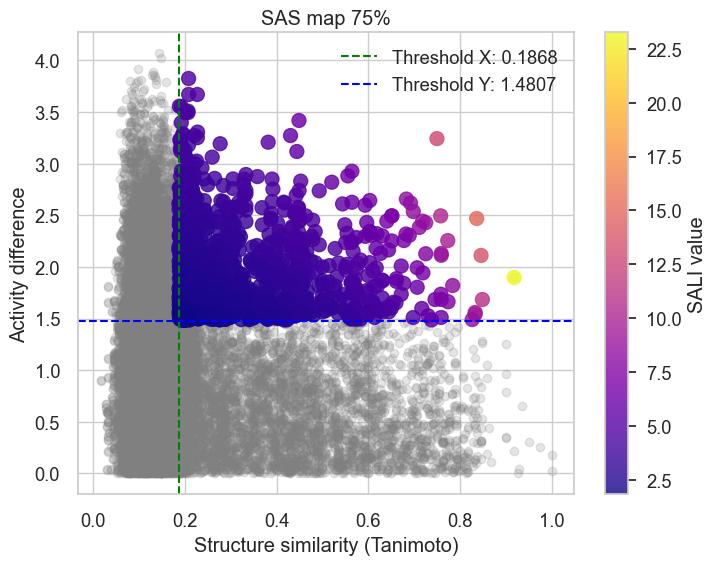

In [98]:
# Calculate thresholds
thresholds_ActivityDiff_75 = merge['Activity difference'].quantile(0.75)
thresholds_Similarity_75 = merge['Structure similarity (Tanimoto)'].quantile(0.75)

# Create the figure before calling SAS_map
plt.figure(figsize=(10, 6), dpi=600)  # Adjust figure size if needed

# Call the SAS_map function
SAS_map(
    merge,
    similarity_column='Structure similarity (Tanimoto)',
    dif_activity_col='Activity difference',
    sali_col='SALI value',
    umbral_x=thresholds_Similarity_75,
    umbral_y=thresholds_ActivityDiff_75,
    set_title='SAS map 75%'
)

plt.show()  # Display the plot

In [99]:
# Calculate the 75th percentile (Q3) for Activity Difference and Structure Similarity
thresholds_ActivityDiff_75 = merge['Activity difference'].quantile(0.75)
thresholds_Similarity_75 = merge['Structure similarity (Tanimoto)'].quantile(0.75)

# Count the number of pairwise comparisons that meet the 75th percentile thresholds
num_valid_comparisons = merge[
    (merge['Activity difference'] >= thresholds_ActivityDiff_75) & 
    (merge['Structure similarity (Tanimoto)'] >= thresholds_Similarity_75)
].shape[0]

# Print thresholds and the number of valid pairwise comparisons
print(f"75th Percentile Threshold for Activity Difference: {thresholds_ActivityDiff_75:.4f}")
print(f"75th Percentile Threshold for Structure Similarity (Tanimoto): {thresholds_Similarity_75:.4f}")
print(f"Number of pairwise comparisons meeting the 75th percentile thresholds: {num_valid_comparisons}")


75th Percentile Threshold for Activity Difference: 1.4807
75th Percentile Threshold for Structure Similarity (Tanimoto): 0.1868
Number of pairwise comparisons meeting the 75th percentile thresholds: 1137


In [100]:
# Calculate the 75th percentile (Q3) for Activity Difference and Structure Similarity
thresholds_ActivityDiff_75 = merge['Activity difference'].quantile(0.75)
thresholds_Similarity_75 = merge['Structure similarity (Tanimoto)'].quantile(0.75)

# Filter the dataframe to keep only rows meeting the 75th percentile thresholds
merge_filtered = merge[
    (merge['Activity difference'] >= thresholds_ActivityDiff_75) & 
    (merge['Structure similarity (Tanimoto)'] >= thresholds_Similarity_75)
]

# Sort by Structure similarity (Tanimoto) in descending order
merge_filtered = merge_filtered.sort_values(by='Structure similarity (Tanimoto)', ascending=False)

# Select relevant columns including SMILES structures
columns_to_save = [
    'Compuesto A', 'pIC50 A', 'Smiles A',  # Molecule A details
    'Compuesto B', 'pIC50 B', 'Smiles B',  # Molecule B details
    'Activity difference', 'Structure similarity (Tanimoto)', 'SALI value'  # Analysis values
]

# Ensure only existing columns are selected
columns_to_save = [col for col in columns_to_save if col in merge_filtered.columns]


In [101]:
merge_filtered[columns_to_save]

pIC50 A                                           Smiles A  pIC50 B  \
5825   5.0605  O=C(O)c1ccc(Cn2c3c(c4ccccc42)CCN(C(=O)c2ccc(O)...   6.9586   
5809   5.0605  O=C(O)c1ccc(Cn2c3c(c4ccccc42)CCN(C(=O)c2ccc(O)...   6.7447   
8884   5.2757           O=C1CCc2cc(=CCC(=O)N3CCC(CCO)CC3)cnc2=N1   7.3872   
1875   4.4895  O=C(c1ccc(O)cc1)N1CCc2c(c3ccccc3n2Cc2ccc(O)cc2)C1   6.9586   
5800   5.0605  O=C(O)c1ccc(Cn2c3c(c4ccccc42)CCN(C(=O)c2ccc(O)...   6.6021   
...       ...                                                ...      ...   
3301   4.7825  COC(=O)CC1Nc2ccc(C(=O)N(C)Cc3cc4ccccc4n3C)cc2C...   6.9508   
2442   4.6737       CN1Cc2cc(C(=O)N(C)Cc3cc4ccccc4n3C)ccc2NCC1=O   6.2924   
2461   4.6737       CN1Cc2cc(C(=O)N(C)Cc3cc4ccccc4n3C)ccc2NCC1=O   6.4815   
2907   4.7352                  O=C(Cc1ccccc1Cl)N1CCC(c2ccccn2)C1   7.2218   
7474   5.2218                   O=C(Cc1ccccc1Cl)N1CCC(c2nccs2)C1   7.0915   

                                               Smiles B  Activity difference  \
5825  O=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3ccccc...               1.8981   
5809  O=C(c1ccc(Cl)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3cccc...               1.6842   
8884         CCCC1CCN(C(=O)CC=c2cnc3c(c2)CCC(=O)N=3)CC1               2.1115   
1875  O=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(O)cc3)c3ccccc...               2.4692   
5800  O=C(c1ccc(O)cc1)N1CCc2c(n(Cc3ccc(F)cc3)c3ccccc...               1.5416   
...                                                 ...                  ...   
3301  Cc1c(C2CN(C(=O)CC=c3cnc4c(c3)CN(C)CC(=O)N=4)C2...               2.1683   
2442  CCCCc1ccc(C(=O)N2CCc3c(n(Cc4ccc(O)cc4)c4ccccc3...               1.6188   
2461  CS(=O)(=O)c1ccc(Cn2c3c(c4ccccc42)CCN(C(=O)c2cc...               1.8078   
2907  COC(=O)C1Cc2cc(=CCC(=O)N3CCC(COc4ccc(F)cc4)CC3...               2.4867   
7474  O=C1N=c2ncc(=CCC(=O)N3CCC(COc4ccc(F)cc4)CC3)cc...               1.8697   

      Structure similarity (Tanimoto)  SALI value  
5825                           0.9184     23.2517  
5809                           0.8491     11.1578  
8884                           0.8462     13.7247  
1875                           0.8367     15.1239  
5800                           0.8333      9.2496  
...                               ...         ...  
3301                           0.1869      2.6668  
2442                           0.1868      1.9907  
2461                           0.1868      2.2231  
2907                           0.1868      3.0580  
7474                           0.1868      2.2992  

[1137 rows x 7 columns]

In [103]:
merge_filtered[columns_to_save].to_excel("filtered_structures_75th_percentile_sorted.xlsx", index=False)

## **References**

* Bajorath, Jürgen. 2014. “Exploring Activity Cliffs from a Chemoinformatics Perspective.” Molecular Informatics 33 (6-7): 438–42.
* David, Laurianne, Amol Thakkar, Rocío Mercado, and Ola Engkvist. 2020. “Molecular Representations in AI-Driven Drug Discovery: A Review and Practical Guide.” Journal of Cheminformatics 12 (1): 56.
* Pérez-Villanueva, Jaime, Oscar Méndez-Lucio, Olivia Soria-Arteche, and José L. Medina-Franco. 2015. “Activity Cliffs and Activity Cliff Generators Based on Chemotype-Related Activity Landscapes.” Molecular Diversity 19 (4): 1021–35.
